In [1]:
from __future__ import print_function
import pylab

import numpy as np

import matplotlib.pyplot as plt
import time
import os
import pickle
import random

import pandas as pd

import random

#from category_encoders import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

plt.style.use('seaborn-white')

pylab.ion()

In [2]:
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi, tan, sinh, cosh, exp, tanh, log, log10
import scipy.special as ssf
import math

In [3]:
from multiprocessing import Pool
from multiprocessing import cpu_count
import emcee
from tqdm import tqdm

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

40 CPUs


In [4]:
def make_lower(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        for j in range(i+1):
            mask[i, j] = 1
    mask = torch.from_numpy(mask)
    return mask

def make_diag(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        mask[i, i] = 1
    mask = torch.from_numpy(mask)
    return mask

In [5]:
def psiHOpoint(n, x):
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHO(n, x):
    x=np.array(x)
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHOall(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)])

def HM(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)]).T

def FM(k, L, x): #k Fourier modes in the interval (-L,L)
    x=np.array(x)
    xkmat = np.reshape(x, [len(x),1])*np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)*np.ones([len(x),1])
    cosmodes = cos(xkmat*pi/L)/sqrt(L)
    sinmodes = sin(xkmat*pi/L)/sqrt(L)
    return np.concatenate((zeromode,cosmodes,sinmodes),axis=1)

def FCpsiHO(n, k, L) :#k Fourier coefficients for the nth harmonic oscillator wavefunction in (-L,L)
    coeff0 = np.array([integrate.quad(lambda x: psiHOpoint(n, x)/sqrt(2*L), -L, L)[0]])
    coeffcos = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*cos(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    coeffsin = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*sin(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    return np.concatenate((coeff0,coeffcos,coeffsin))

In [6]:
def FM0(k, L, x): #k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)
    cosmodes = cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def D2FM0(k, L, x): #second derivative of k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 0
    cosmodes = -(kvec*pi/L)**2*cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = -(kvec*pi/L)**2*sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def H_HO_FM_int(k, L):
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(x**2*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

def V_AHO(x):
    return -x**2/2-x+x**4/16

def H_AHO_FM_int(k, L, V): #V is the function that calculates the potential
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(2*V(x)*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

In [7]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def K(n):
    upper = -1*np.ones(n-1)
    center = np.concatenate(([1],2*np.ones(n-2),[1]))
    return tridiag(upper,center,upper)

def covHO(n,a):
    upper = -1*np.ones(n-1)
    center = np.concatenate(([1+a**2],(2+a**2)*np.ones(n-2),[1+a**2]))
    return np.linalg.inv(1/a*tridiag(upper,center,upper))

def solveHOE(t,a,b,T):
    t=np.array(t)
    return a*cosh(t) + (-a*cosh(T)/sinh(T) + b/sinh(T))*sinh(t)

In [8]:
def V_AHO(x):
    return -x**2/2-x+x**4/16

def lnprob_V(x, n, a):
    return -np.dot(x,np.dot(K(n),x))/2.0/a - np.sum(a*V_AHO(x))

In [9]:
class QML(nn.Module):
    def __init__(self, n_ES, n_B):
        super(QML, self).__init__()
        
        self.n_Ba = n_B
        self.n_EL = n_ES + 1
        
        self.levels = torch.nn.Parameter(torch.from_numpy(np.random.uniform(1,2,self.n_EL)))
        self.levels.requires_grad = True
        
        self.var_BaC = torch.nn.Parameter(torch.from_numpy(np.random.uniform(-1,1,[self.n_Ba, self.n_EL])))
        self.var_BaC.requires_grad = True
        
        self.mask = (make_lower(self.n_EL) - make_diag(self.n_EL) ) > 0 #convert to boolean
        self.diag = make_diag(self.n_EL) > 0 #convert to boolean   
        
    def forward(self, in_x, in_y):
        
        norms_BaC = torch.linalg.norm(self.var_BaC, dim = 0)
        var_BaC_N = self.var_BaC/norms_BaC
        logits = F.softmin(self.levels, dim = 0)
        
        c_orth = 1000
        loss_orth = c_orth * torch.mean(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1),var_BaC_N) \
                                                                  , self.mask)**2)
        
        loss_ML = -1 * torch.mean(torch.matmul( torch.matmul(in_x, var_BaC_N) * torch.matmul(in_y, var_BaC_N) \
                    , torch.log(logits*(10**4.)+1) ) )
        
        loss = loss_orth + loss_ML
        
        return loss, loss_ML, loss_orth, self.levels, logits 

In [10]:
def main_train_states_QML(G, T, nwalkers = 100, n_slice = 40, n_HM = 10, batch_size = 5, epochs = 200000, step = 1e-3):
    
    beta = 1/T
    a = beta/n_slice
    
    start_time = time.time()
    
    ##initialise MCMC sampling
    path0 = np.random.rand(n_slice * nwalkers).reshape((nwalkers, n_slice))
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, n_slice, lnprob_V, args = [n_slice, a], pool=pool)
        #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
        pos, prob, state = sampler.run_mcmc(path0, 500, progress=True)
        sampler.reset() 
    
    
        optimiser = torch.optim.Adam(G.parameters(), lr=step)
    
    
        loss_hist = np.zeros((epochs,), dtype = float)
        loss_ML_hist = np.zeros((epochs,), dtype = float)
        loss_orth_hist = np.zeros((epochs,), dtype = float)
    
        levels_hist = np.zeros((epochs, G.n_EL), dtype = float)
        logits_hist = np.zeros((epochs, G.n_EL), dtype = float)
        
        
    
        for i in range(epochs):
        
        
            sampler.run_mcmc(pos, batch_size, progress = False)
            paths = sampler.get_chain(flat = True)
            pos = paths[nwalkers * (batch_size-1): nwalkers * batch_size, :]
            sampler.reset() 
            
            in_x = torch.from_numpy(HM(n_Hm, pos[:, 0]))
            in_y = torch.from_numpy(HM(n_Hm, pos[:, -1]))
                    
            [loss, loss_ML, loss_orth, levels, logits] = G(in_x, in_y)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        
        
            loss_hist[i] = loss.tolist()
            loss_ML_hist[i] = loss_ML.tolist()
            loss_orth_hist[i] = loss_orth.tolist()
        
            levels_hist[i, :] = levels.tolist()
            logits_hist[i, :] = logits.tolist()
            
           
        
            if i % 1000 == 0:
                
                print('Batch number ', i)
                print('Loss: ', loss_hist[i])
                print('Loss_orth: ', loss_orth_hist[i])
                print('Loss_ML: ', loss_ML_hist[i])
                print('Logits: ', logits)
                
                end_time = time.time()
                print('Time taken: {0:.3f} seconds'.format(end_time - start_time))
                start_time = time.time()
                
                print('@----------------------------------------------------------@')
                #writer.add_summary(summary, i)
                #writer.flush()
                
            
        
                
    var_BaC = G.var_BaC
    norms_BaC = torch.linalg.norm(var_BaC, dim = 0)
    var_BaC_N = (var_BaC / norms_BaC).detach().numpy() #normalise the coefficients of basis states
    levels_hist = np.array(levels_hist)
    logits_hist = np.array(logits_hist)
    
    
    ##Sort energy levels and associated coefficients of basis states in ascending order
    fin_EL = G.levels
    fin_EL = fin_EL.detach()
    fin_logits = F.softmin(fin_EL, dim = 0)
    fin_EL = fin_EL.numpy()
    fin_logits = fin_logits.numpy()
    
    fin_EL_argsort = fin_EL.argsort()
    levels_hist = levels_hist[:, fin_EL_argsort]
    logits_hist = logits_hist[:, fin_EL_argsort]
    var_BaC_N = var_BaC_N[:, fin_EL_argsort]
    fin_EL = fin_EL[fin_EL_argsort]
    fin_logits = fin_logits[fin_EL_argsort]
    #EL_ranks = np.empty_like(fin_EL_argsort)
    #EL_ranks[fin_EL_argsort] = np.arange(len(fin_EL))
    
    return loss_hist, loss_ML_hist, loss_orth_hist, levels_hist, logits_hist, var_BaC_N, fin_EL, fin_logits

In [11]:
n_Hm = 10
n_EL = 10
T = 2
qml_AHO_HM = QML(n_EL, n_Hm+1)

[loss_hist, loss_ML_hist, loss_orth_hist, levels_hist, logits_hist, var_HC_N, levels_fin, logits_fin] = \
                                                                main_train_states_QML(qml_AHO_HM, T)

  0%|          | 0/500 [00:00<?, ?it/s]

  3%|▎         | 15/500 [00:00<00:03, 147.18it/s]

  6%|▌         | 30/500 [00:00<00:03, 144.91it/s]

  9%|▉         | 46/500 [00:00<00:03, 147.48it/s]

 13%|█▎        | 63/500 [00:00<00:02, 151.65it/s]

 16%|█▌        | 80/500 [00:00<00:02, 155.81it/s]

 19%|█▉        | 96/500 [00:00<00:02, 156.31it/s]

 22%|██▏       | 112/500 [00:00<00:02, 154.84it/s]

 26%|██▌       | 129/500 [00:00<00:02, 158.03it/s]

 29%|██▉       | 146/500 [00:00<00:02, 158.84it/s]

 32%|███▏      | 162/500 [00:01<00:02, 152.73it/s]

 36%|███▌      | 178/500 [00:01<00:02, 154.67it/s]

 39%|███▉      | 195/500 [00:01<00:01, 158.20it/s]

 42%|████▏     | 212/500 [00:01<00:01, 160.48it/s]

 46%|████▌     | 229/500 [00:01<00:01, 162.55it/s]

 49%|████▉     | 246/500 [00:01<00:01, 162.52it/s]

 53%|█████▎    | 263/500 [00:01<00:01, 163.88it/s]

 56%|█████▌    | 280/500 [00:01<00:01, 164.07it/s]

 59%|█████▉    | 297/500 [00:01<00:01, 162.37it/s]

 63%|██████▎   | 314/500 [00:01<00:01, 164.35it/s]

 66%|██████▌   | 331/500 [00:02<00:01, 161.38it/s]

 70%|██████▉   | 348/500 [00:02<00:00, 159.79it/s]

 73%|███████▎  | 364/500 [00:02<00:00, 158.63it/s]

 76%|███████▌  | 381/500 [00:02<00:00, 161.20it/s]

 80%|███████▉  | 399/500 [00:02<00:00, 163.93it/s]

 83%|████████▎ | 416/500 [00:02<00:00, 165.69it/s]

 87%|████████▋ | 433/500 [00:02<00:00, 166.50it/s]

 90%|█████████ | 450/500 [00:02<00:00, 166.41it/s]

 93%|█████████▎| 467/500 [00:02<00:00, 166.64it/s]

 97%|█████████▋| 484/500 [00:03<00:00, 167.16it/s]

100%|██████████| 500/500 [00:03<00:00, 160.88it/s]

/home/scl489/.env/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Batch number  0
Loss:  122.40774338540888
Loss_orth:  126.52740285513251
Loss_ML:  -4.119659469723623
Logits:  tensor([0.0653, 0.1228, 0.1281, 0.0690, 0.1352, 0.1130, 0.1176, 0.0669, 0.0714,
        0.0540, 0.0566], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 6.377 seconds
@----------------------------------------------------------@


Batch number  1000
Loss:  -3.7515418158194738
Loss_orth:  0.060871199225172694
Loss_ML:  -3.8124130150446462
Logits:  tensor([0.1037, 0.1410, 0.0992, 0.0470, 0.0749, 0.0892, 0.0748, 0.0736, 0.0943,
        0.0735, 0.1288], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.902 seconds
@----------------------------------------------------------@


Batch number  2000
Loss:  -3.7754944207923145
Loss_orth:  0.09504327449860148
Loss_ML:  -3.870537695290916
Logits:  tensor([0.1475, 0.0969, 0.0891, 0.0369, 0.0479, 0.0877, 0.0566, 0.0436, 0.1190,
        0.0626, 0.2121], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.877 seconds
@----------------------------------------------------------@


Batch number  3000
Loss:  -4.0577311864409795
Loss_orth:  0.05402773142888774
Loss_ML:  -4.111758917869867
Logits:  tensor([0.1443, 0.1073, 0.0907, 0.0371, 0.0441, 0.0889, 0.0574, 0.0440, 0.1074,
        0.0620, 0.2169], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.976 seconds
@----------------------------------------------------------@


Batch number  4000
Loss:  -3.6706149657501927
Loss_orth:  0.05668098061117507
Loss_ML:  -3.7272959463613677
Logits:  tensor([0.1519, 0.1095, 0.0925, 0.0323, 0.0369, 0.0888, 0.0481, 0.0415, 0.1012,
        0.0591, 0.2382], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.806 seconds
@----------------------------------------------------------@


Batch number  5000
Loss:  -5.175315950760097
Loss_orth:  0.10925033128826366
Loss_ML:  -5.2845662820483605
Logits:  tensor([0.1684, 0.0918, 0.0839, 0.0256, 0.0351, 0.0895, 0.0481, 0.0332, 0.0935,
        0.0465, 0.2843], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.642 seconds
@----------------------------------------------------------@


Batch number  6000
Loss:  -4.104475827546173
Loss_orth:  0.06711471837912707
Loss_ML:  -4.1715905459253
Logits:  tensor([0.1890, 0.0787, 0.0820, 0.0143, 0.0243, 0.0756, 0.0376, 0.0203, 0.0605,
        0.0270, 0.3906], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.659 seconds
@----------------------------------------------------------@


Batch number  7000
Loss:  -3.840098450607572
Loss_orth:  0.040207153336699525
Loss_ML:  -3.8803056039442714
Logits:  tensor([0.1891, 0.0870, 0.0868, 0.0132, 0.0226, 0.0727, 0.0406, 0.0311, 0.0388,
        0.0224, 0.3957], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.528 seconds
@----------------------------------------------------------@


Batch number  8000
Loss:  -4.2562052262431935
Loss_orth:  0.050253118643434895
Loss_ML:  -4.306458344886629
Logits:  tensor([0.1878, 0.0965, 0.0996, 0.0134, 0.0209, 0.0848, 0.0372, 0.0362, 0.0288,
        0.0209, 0.3740], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.579 seconds
@----------------------------------------------------------@


Batch number  9000
Loss:  -3.416315311944179
Loss_orth:  0.03879024106250989
Loss_ML:  -3.455105553006689
Logits:  tensor([0.1846, 0.0715, 0.0977, 0.0080, 0.0132, 0.0810, 0.0305, 0.0245, 0.0142,
        0.0141, 0.4608], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.694 seconds
@----------------------------------------------------------@


Batch number  10000
Loss:  -4.584799496092271
Loss_orth:  0.022917797042778736
Loss_ML:  -4.60771729313505
Logits:  tensor([0.1919, 0.0735, 0.1012, 0.0077, 0.0111, 0.0838, 0.0291, 0.0245, 0.0117,
        0.0126, 0.4528], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.455 seconds
@----------------------------------------------------------@


Batch number  11000
Loss:  -4.814572359976303
Loss_orth:  0.02402764572404573
Loss_ML:  -4.838600005700349
Logits:  tensor([0.1925, 0.0597, 0.0972, 0.0046, 0.0085, 0.0954, 0.0274, 0.0164, 0.0074,
        0.0087, 0.4823], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.439 seconds
@----------------------------------------------------------@


Batch number  12000
Loss:  -4.53165313393472
Loss_orth:  0.01775900838821904
Loss_ML:  -4.549412142322939
Logits:  tensor([0.1988, 0.0683, 0.0950, 0.0042, 0.0078, 0.1002, 0.0324, 0.0192, 0.0069,
        0.0091, 0.4581], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.562 seconds
@----------------------------------------------------------@


Batch number  13000
Loss:  -4.185258750296633
Loss_orth:  0.012401431007575939
Loss_ML:  -4.197660181304209
Logits:  tensor([0.2023, 0.0759, 0.0932, 0.0049, 0.0057, 0.0894, 0.0263, 0.0270, 0.0064,
        0.0088, 0.4601], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.294 seconds
@----------------------------------------------------------@


Batch number  14000
Loss:  -3.8396218670949103
Loss_orth:  0.010165986048364476
Loss_ML:  -3.8497878531432748
Logits:  tensor([0.1958, 0.0870, 0.0970, 0.0053, 0.0048, 0.0942, 0.0296, 0.0296, 0.0065,
        0.0097, 0.4404], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.324 seconds
@----------------------------------------------------------@


Batch number  15000
Loss:  -4.692443950944466
Loss_orth:  0.012385846742138723
Loss_ML:  -4.704829797686605
Logits:  tensor([0.1972, 0.0704, 0.0878, 0.0040, 0.0035, 0.0863, 0.0258, 0.0222, 0.0057,
        0.0071, 0.4901], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.468 seconds
@----------------------------------------------------------@


Batch number  16000
Loss:  -4.683298365107998
Loss_orth:  0.022656332910243278
Loss_ML:  -4.705954698018241
Logits:  tensor([0.2252, 0.0604, 0.0898, 0.0035, 0.0028, 0.0865, 0.0247, 0.0201, 0.0050,
        0.0063, 0.4755], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.604 seconds
@----------------------------------------------------------@


Batch number  17000
Loss:  -4.242060525427283
Loss_orth:  0.008231221361936924
Loss_ML:  -4.2502917467892205
Logits:  tensor([0.2193, 0.0499, 0.0760, 0.0034, 0.0027, 0.0928, 0.0297, 0.0185, 0.0050,
        0.0072, 0.4955], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.675 seconds
@----------------------------------------------------------@


Batch number  18000
Loss:  -4.680794209532823
Loss_orth:  0.012731659313630033
Loss_ML:  -4.693525868846453
Logits:  tensor([0.2060, 0.0761, 0.0898, 0.0041, 0.0035, 0.1093, 0.0410, 0.0264, 0.0068,
        0.0095, 0.4275], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.048 seconds
@----------------------------------------------------------@


Batch number  19000
Loss:  -4.581042011304308
Loss_orth:  0.008686014131752795
Loss_ML:  -4.58972802543606
Logits:  tensor([0.2104, 0.0666, 0.0799, 0.0043, 0.0029, 0.0918, 0.0333, 0.0258, 0.0061,
        0.0090, 0.4699], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.641 seconds
@----------------------------------------------------------@


Batch number  20000
Loss:  -4.677713428812901
Loss_orth:  0.016812367217604082
Loss_ML:  -4.694525796030505
Logits:  tensor([0.2185, 0.0703, 0.0797, 0.0043, 0.0025, 0.0929, 0.0276, 0.0240, 0.0051,
        0.0079, 0.4673], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.688 seconds
@----------------------------------------------------------@


Batch number  21000
Loss:  -4.078902884785221
Loss_orth:  0.022908476026036677
Loss_ML:  -4.101811360811258
Logits:  tensor([0.2115, 0.0916, 0.0905, 0.0041, 0.0020, 0.0947, 0.0251, 0.0265, 0.0042,
        0.0065, 0.4434], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.748 seconds
@----------------------------------------------------------@


Batch number  22000
Loss:  -5.125986707612572
Loss_orth:  0.017970011170712633
Loss_ML:  -5.143956718783285
Logits:  tensor([0.2144, 0.0849, 0.0850, 0.0055, 0.0023, 0.1045, 0.0319, 0.0289, 0.0058,
        0.0085, 0.4283], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.884 seconds
@----------------------------------------------------------@


Batch number  23000
Loss:  -4.534747288295655
Loss_orth:  0.00797791825431361
Loss_ML:  -4.542725206549969
Logits:  tensor([0.2004, 0.1047, 0.0796, 0.0069, 0.0026, 0.1012, 0.0296, 0.0359, 0.0061,
        0.0081, 0.4249], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.793 seconds
@----------------------------------------------------------@


Batch number  24000
Loss:  -4.440762433305859
Loss_orth:  0.006858758538831358
Loss_ML:  -4.44762119184469
Logits:  tensor([0.2028, 0.0747, 0.0782, 0.0067, 0.0026, 0.0896, 0.0265, 0.0262, 0.0057,
        0.0077, 0.4795], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.010 seconds
@----------------------------------------------------------@


Batch number  25000
Loss:  -4.057316284101996
Loss_orth:  0.008156587802989336
Loss_ML:  -4.065472871904985
Logits:  tensor([0.2036, 0.0836, 0.0886, 0.0059, 0.0025, 0.1029, 0.0319, 0.0284, 0.0060,
        0.0080, 0.4387], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.625 seconds
@----------------------------------------------------------@


Batch number  26000
Loss:  -4.551849012034652
Loss_orth:  0.0049574084796347945
Loss_ML:  -4.556806420514287
Logits:  tensor([0.2136, 0.0720, 0.0726, 0.0049, 0.0021, 0.1107, 0.0295, 0.0239, 0.0048,
        0.0076, 0.4584], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.135 seconds
@----------------------------------------------------------@


Batch number  27000
Loss:  -4.284929695832854
Loss_orth:  0.012941598486214003
Loss_ML:  -4.2978712943190684
Logits:  tensor([0.2172, 0.0801, 0.0747, 0.0053, 0.0023, 0.0978, 0.0255, 0.0272, 0.0048,
        0.0080, 0.4571], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.148 seconds
@----------------------------------------------------------@


Batch number  28000
Loss:  -4.068658319830977
Loss_orth:  0.007364604418822866
Loss_ML:  -4.076022924249799
Logits:  tensor([0.1969, 0.0787, 0.0779, 0.0043, 0.0019, 0.0990, 0.0295, 0.0248, 0.0040,
        0.0067, 0.4763], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.052 seconds
@----------------------------------------------------------@


Batch number  29000
Loss:  -4.417104252778694
Loss_orth:  0.009873282830395607
Loss_ML:  -4.4269775356090895
Logits:  tensor([0.1992, 0.0981, 0.0810, 0.0051, 0.0022, 0.1001, 0.0275, 0.0295, 0.0047,
        0.0078, 0.4447], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.273 seconds
@----------------------------------------------------------@


Batch number  30000
Loss:  -4.118501932617329
Loss_orth:  0.01418528089304696
Loss_ML:  -4.132687213510376
Logits:  tensor([0.2081, 0.0891, 0.0768, 0.0059, 0.0026, 0.1001, 0.0324, 0.0286, 0.0050,
        0.0102, 0.4413], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.071 seconds
@----------------------------------------------------------@


Batch number  31000
Loss:  -4.054353277974075
Loss_orth:  0.006725948543094148
Loss_ML:  -4.061079226517169
Logits:  tensor([0.2177, 0.0700, 0.0737, 0.0052, 0.0022, 0.1071, 0.0305, 0.0225, 0.0039,
        0.0089, 0.4582], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.925 seconds
@----------------------------------------------------------@


Batch number  32000
Loss:  -4.292607768656289
Loss_orth:  0.006412142939556114
Loss_ML:  -4.299019911595845
Logits:  tensor([0.2192, 0.0787, 0.0699, 0.0048, 0.0020, 0.1099, 0.0264, 0.0227, 0.0042,
        0.0076, 0.4545], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.035 seconds
@----------------------------------------------------------@


Batch number  33000
Loss:  -4.1681305610496056
Loss_orth:  0.010276830257830357
Loss_ML:  -4.178407391307436
Logits:  tensor([0.2087, 0.0677, 0.0638, 0.0053, 0.0020, 0.1059, 0.0290, 0.0238, 0.0050,
        0.0082, 0.4807], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.099 seconds
@----------------------------------------------------------@


Batch number  34000
Loss:  -4.2158465675005345
Loss_orth:  0.004456472314751337
Loss_ML:  -4.220303039815286
Logits:  tensor([0.2029, 0.0662, 0.0628, 0.0045, 0.0015, 0.1046, 0.0253, 0.0204, 0.0043,
        0.0068, 0.5007], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.976 seconds
@----------------------------------------------------------@


Batch number  35000
Loss:  -4.475171834590975
Loss_orth:  0.012291859212766458
Loss_ML:  -4.487463693803741
Logits:  tensor([0.2120, 0.0644, 0.0759, 0.0046, 0.0015, 0.1261, 0.0304, 0.0208, 0.0043,
        0.0082, 0.4518], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.036 seconds
@----------------------------------------------------------@


Batch number  36000
Loss:  -4.127623523310055
Loss_orth:  0.015032079488443387
Loss_ML:  -4.142655602798498
Logits:  tensor([0.2135, 0.0740, 0.0682, 0.0034, 0.0012, 0.1163, 0.0261, 0.0187, 0.0038,
        0.0062, 0.4687], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.235 seconds
@----------------------------------------------------------@


Batch number  37000
Loss:  -4.384152608942744
Loss_orth:  0.009121461251515283
Loss_ML:  -4.393274070194259
Logits:  tensor([0.2204, 0.0691, 0.0682, 0.0037, 0.0013, 0.1150, 0.0342, 0.0228, 0.0047,
        0.0077, 0.4529], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.964 seconds
@----------------------------------------------------------@


Batch number  38000
Loss:  -4.03148082649107
Loss_orth:  0.007423943685042694
Loss_ML:  -4.038904770176113
Logits:  tensor([0.2193, 0.0668, 0.0604, 0.0033, 0.0013, 0.1011, 0.0275, 0.0207, 0.0039,
        0.0067, 0.4889], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.961 seconds
@----------------------------------------------------------@


Batch number  39000
Loss:  -4.852016876989957
Loss_orth:  0.009806250793293116
Loss_ML:  -4.86182312778325
Logits:  tensor([0.2066, 0.0746, 0.0665, 0.0053, 0.0017, 0.1108, 0.0346, 0.0266, 0.0046,
        0.0094, 0.4593], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.791 seconds
@----------------------------------------------------------@


Batch number  40000
Loss:  -4.313187473212021
Loss_orth:  0.014749567069584177
Loss_ML:  -4.327937040281605
Logits:  tensor([0.2040, 0.1036, 0.0771, 0.0054, 0.0014, 0.1170, 0.0305, 0.0300, 0.0041,
        0.0085, 0.4183], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.076 seconds
@----------------------------------------------------------@


Batch number  41000
Loss:  -4.171999347709293
Loss_orth:  0.006523387418411374
Loss_ML:  -4.178522735127705
Logits:  tensor([0.1977, 0.0962, 0.0746, 0.0067, 0.0015, 0.1227, 0.0393, 0.0343, 0.0046,
        0.0110, 0.4115], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.851 seconds
@----------------------------------------------------------@


Batch number  42000
Loss:  -4.7137685045353725
Loss_orth:  0.006708042738611604
Loss_ML:  -4.720476547273984
Logits:  tensor([0.2069, 0.0844, 0.0644, 0.0045, 0.0011, 0.1138, 0.0294, 0.0242, 0.0035,
        0.0086, 0.4592], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.292 seconds
@----------------------------------------------------------@


Batch number  43000
Loss:  -3.880767489046701
Loss_orth:  0.013999913719889914
Loss_ML:  -3.894767402766591
Logits:  tensor([0.2071, 0.0843, 0.0654, 0.0047, 0.0009, 0.1173, 0.0294, 0.0244, 0.0031,
        0.0081, 0.4553], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.675 seconds
@----------------------------------------------------------@


Batch number  44000
Loss:  -4.725099452851521
Loss_orth:  0.017006199091038548
Loss_ML:  -4.742105651942559
Logits:  tensor([0.2218, 0.0762, 0.0704, 0.0048, 0.0009, 0.1266, 0.0349, 0.0231, 0.0031,
        0.0085, 0.4295], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.801 seconds
@----------------------------------------------------------@


Batch number  45000
Loss:  -4.578664115572109
Loss_orth:  0.005711459667252048
Loss_ML:  -4.584375575239361
Logits:  tensor([0.2207, 0.0579, 0.0593, 0.0046, 0.0009, 0.1171, 0.0308, 0.0175, 0.0028,
        0.0086, 0.4799], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.845 seconds
@----------------------------------------------------------@


Batch number  46000
Loss:  -4.2314367855085155
Loss_orth:  0.011553019270348542
Loss_ML:  -4.242989804778864
Logits:  tensor([0.2091, 0.0906, 0.0736, 0.0090, 0.0014, 0.1201, 0.0347, 0.0327, 0.0047,
        0.0141, 0.4099], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.392 seconds
@----------------------------------------------------------@


Batch number  47000
Loss:  -4.091854721058304
Loss_orth:  0.007698914398950584
Loss_ML:  -4.099553635457255
Logits:  tensor([0.2057, 0.0480, 0.0480, 0.0058, 0.0010, 0.0940, 0.0235, 0.0172, 0.0033,
        0.0096, 0.5440], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.467 seconds
@----------------------------------------------------------@


Batch number  48000
Loss:  -4.622439348172098
Loss_orth:  0.01184054004979632
Loss_ML:  -4.6342798882218945
Logits:  tensor([0.2093, 0.0784, 0.0634, 0.0060, 0.0010, 0.1123, 0.0268, 0.0207, 0.0033,
        0.0096, 0.4693], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.449 seconds
@----------------------------------------------------------@


Batch number  49000
Loss:  -3.7306218547683776
Loss_orth:  0.008832246251113923
Loss_ML:  -3.7394541010194917
Logits:  tensor([0.2010, 0.0572, 0.0534, 0.0051, 0.0009, 0.1013, 0.0240, 0.0168, 0.0028,
        0.0085, 0.5289], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.650 seconds
@----------------------------------------------------------@


Batch number  50000
Loss:  -4.464835051373484
Loss_orth:  0.004870633267596674
Loss_ML:  -4.469705684641081
Logits:  tensor([0.2253, 0.0633, 0.0598, 0.0064, 0.0011, 0.1029, 0.0291, 0.0214, 0.0038,
        0.0105, 0.4765], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.564 seconds
@----------------------------------------------------------@


Batch number  51000
Loss:  -4.2580678794135345
Loss_orth:  0.010357213895920482
Loss_ML:  -4.268425093309455
Logits:  tensor([0.2006, 0.0809, 0.0645, 0.0060, 0.0013, 0.1154, 0.0349, 0.0238, 0.0035,
        0.0113, 0.4578], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.039 seconds
@----------------------------------------------------------@


Batch number  52000
Loss:  -4.195800728780872
Loss_orth:  0.010495904477613997
Loss_ML:  -4.206296633258487
Logits:  tensor([0.2028, 0.0727, 0.0530, 0.0057, 0.0011, 0.1066, 0.0273, 0.0216, 0.0031,
        0.0096, 0.4966], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.914 seconds
@----------------------------------------------------------@


Batch number  53000
Loss:  -4.504263206316491
Loss_orth:  0.0036277857873904394
Loss_ML:  -4.5078909921038814
Logits:  tensor([0.2223, 0.0580, 0.0576, 0.0046, 0.0010, 0.1128, 0.0286, 0.0161, 0.0027,
        0.0086, 0.4878], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.630 seconds
@----------------------------------------------------------@


Batch number  54000
Loss:  -4.672527655983854
Loss_orth:  0.014491916303774884
Loss_ML:  -4.687019572287628
Logits:  tensor([0.2126, 0.0805, 0.0650, 0.0062, 0.0011, 0.1161, 0.0329, 0.0261, 0.0037,
        0.0105, 0.4453], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.451 seconds
@----------------------------------------------------------@


Batch number  55000
Loss:  -4.2800962390555455
Loss_orth:  0.009112591873291874
Loss_ML:  -4.289208830928837
Logits:  tensor([0.2114, 0.0834, 0.0658, 0.0055, 0.0012, 0.1187, 0.0317, 0.0226, 0.0034,
        0.0113, 0.4451], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.646 seconds
@----------------------------------------------------------@


Batch number  56000
Loss:  -5.036779802110911
Loss_orth:  0.017230222138931182
Loss_ML:  -5.054010024249842
Logits:  tensor([0.2214, 0.0647, 0.0660, 0.0062, 0.0011, 0.1202, 0.0337, 0.0225, 0.0033,
        0.0107, 0.4502], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.734 seconds
@----------------------------------------------------------@


Batch number  57000
Loss:  -4.7202448342056815
Loss_orth:  0.007205612382095784
Loss_ML:  -4.727450446587778
Logits:  tensor([0.2003, 0.0698, 0.0563, 0.0064, 0.0011, 0.1011, 0.0320, 0.0203, 0.0034,
        0.0101, 0.4991], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.826 seconds
@----------------------------------------------------------@


Batch number  58000
Loss:  -4.675533472832088
Loss_orth:  0.005437934567223596
Loss_ML:  -4.680971407399311
Logits:  tensor([0.2069, 0.0746, 0.0573, 0.0051, 0.0010, 0.1072, 0.0309, 0.0161, 0.0027,
        0.0089, 0.4893], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.839 seconds
@----------------------------------------------------------@


Batch number  59000
Loss:  -4.1252652951660576
Loss_orth:  0.011310512607056919
Loss_ML:  -4.136575807773115
Logits:  tensor([0.2168, 0.0727, 0.0590, 0.0054, 0.0009, 0.1104, 0.0269, 0.0206, 0.0027,
        0.0083, 0.4762], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.811 seconds
@----------------------------------------------------------@


Batch number  60000
Loss:  -4.771805493873646
Loss_orth:  0.005368849759329471
Loss_ML:  -4.777174343632975
Logits:  tensor([0.2203, 0.0661, 0.0584, 0.0049, 0.0007, 0.1133, 0.0278, 0.0191, 0.0024,
        0.0080, 0.4791], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.763 seconds
@----------------------------------------------------------@


Batch number  61000
Loss:  -4.910659357313717
Loss_orth:  0.010982867689132043
Loss_ML:  -4.9216422250028495
Logits:  tensor([0.2070, 0.0583, 0.0549, 0.0059, 0.0009, 0.1089, 0.0293, 0.0176, 0.0032,
        0.0093, 0.5047], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.655 seconds
@----------------------------------------------------------@


Batch number  62000
Loss:  -3.5817600968011556
Loss_orth:  0.004086124919086193
Loss_ML:  -3.585846221720242
Logits:  tensor([0.2172, 0.0586, 0.0586, 0.0050, 0.0008, 0.1098, 0.0307, 0.0173, 0.0028,
        0.0093, 0.4898], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.678 seconds
@----------------------------------------------------------@


Batch number  63000
Loss:  -4.513442292114818
Loss_orth:  0.005922963764756974
Loss_ML:  -4.519365255879575
Logits:  tensor([0.2141, 0.0806, 0.0574, 0.0035, 0.0006, 0.1171, 0.0296, 0.0166, 0.0021,
        0.0081, 0.4703], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.872 seconds
@----------------------------------------------------------@


Batch number  64000
Loss:  -4.557913311435707
Loss_orth:  0.005075568660161152
Loss_ML:  -4.562988880095868
Logits:  tensor([0.2193, 0.0686, 0.0606, 0.0051, 0.0007, 0.1194, 0.0333, 0.0231, 0.0027,
        0.0098, 0.4575], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.470 seconds
@----------------------------------------------------------@


Batch number  65000
Loss:  -4.430336267937789
Loss_orth:  0.004145371117279283
Loss_ML:  -4.434481639055068
Logits:  tensor([0.2189, 0.0514, 0.0527, 0.0049, 0.0007, 0.1093, 0.0256, 0.0164, 0.0026,
        0.0076, 0.5100], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.349 seconds
@----------------------------------------------------------@


Batch number  66000
Loss:  -3.9898927595934386
Loss_orth:  0.009894033008974148
Loss_ML:  -3.999786792602413
Logits:  tensor([0.2221, 0.0653, 0.0538, 0.0048, 0.0007, 0.1264, 0.0262, 0.0142, 0.0029,
        0.0070, 0.4767], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.632 seconds
@----------------------------------------------------------@


Batch number  67000
Loss:  -4.779723950074542
Loss_orth:  0.010863383591707437
Loss_ML:  -4.79058733366625
Logits:  tensor([0.2105, 0.0713, 0.0557, 0.0058, 0.0008, 0.1078, 0.0302, 0.0211, 0.0031,
        0.0087, 0.4850], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.982 seconds
@----------------------------------------------------------@


Batch number  68000
Loss:  -5.228372169081819
Loss_orth:  0.006492651405710945
Loss_ML:  -5.23486482048753
Logits:  tensor([0.2262, 0.0685, 0.0631, 0.0051, 0.0007, 0.1179, 0.0324, 0.0189, 0.0027,
        0.0089, 0.4557], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.494 seconds
@----------------------------------------------------------@


Batch number  69000
Loss:  -4.731869064620126
Loss_orth:  0.004081175631079467
Loss_ML:  -4.7359502402512055
Logits:  tensor([0.2225, 0.0774, 0.0649, 0.0056, 0.0007, 0.1297, 0.0323, 0.0218, 0.0027,
        0.0095, 0.4330], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.132 seconds
@----------------------------------------------------------@


Batch number  70000
Loss:  -3.925679639472891
Loss_orth:  0.0060543766031320384
Loss_ML:  -3.931734016076023
Logits:  tensor([0.2142, 0.0707, 0.0587, 0.0070, 0.0008, 0.1092, 0.0358, 0.0229, 0.0034,
        0.0122, 0.4652], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.850 seconds
@----------------------------------------------------------@


Batch number  71000
Loss:  -3.7368344019223256
Loss_orth:  0.006844361090124465
Loss_ML:  -3.74367876301245
Logits:  tensor([0.2157, 0.0686, 0.0571, 0.0068, 0.0009, 0.1172, 0.0295, 0.0215, 0.0033,
        0.0110, 0.4685], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.086 seconds
@----------------------------------------------------------@


Batch number  72000
Loss:  -4.90343848868569
Loss_orth:  0.004491709772301189
Loss_ML:  -4.907930198457991
Logits:  tensor([0.2193, 0.0687, 0.0623, 0.0069, 0.0009, 0.1208, 0.0337, 0.0211, 0.0032,
        0.0111, 0.4520], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.243 seconds
@----------------------------------------------------------@


Batch number  73000
Loss:  -3.9310034739515505
Loss_orth:  0.012506286337886547
Loss_ML:  -3.943509760289437
Logits:  tensor([0.2156, 0.0806, 0.0597, 0.0071, 0.0010, 0.1270, 0.0356, 0.0243, 0.0035,
        0.0117, 0.4339], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.226 seconds
@----------------------------------------------------------@


Batch number  74000
Loss:  -4.304636784221071
Loss_orth:  0.010688117782052378
Loss_ML:  -4.315324902003123
Logits:  tensor([0.2161, 0.0723, 0.0500, 0.0042, 0.0006, 0.1115, 0.0260, 0.0162, 0.0022,
        0.0080, 0.4929], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.143 seconds
@----------------------------------------------------------@


Batch number  75000
Loss:  -4.1586320124851275
Loss_orth:  0.006764203304546351
Loss_ML:  -4.165396215789674
Logits:  tensor([0.2145, 0.0849, 0.0637, 0.0049, 0.0006, 0.1241, 0.0303, 0.0205, 0.0023,
        0.0085, 0.4457], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.092 seconds
@----------------------------------------------------------@


Batch number  76000
Loss:  -4.510336025963167
Loss_orth:  0.007016206604490815
Loss_ML:  -4.517352232567658
Logits:  tensor([0.2119, 0.0685, 0.0523, 0.0044, 0.0006, 0.1091, 0.0272, 0.0170, 0.0021,
        0.0088, 0.4981], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.402 seconds
@----------------------------------------------------------@


Batch number  77000
Loss:  -4.397178956586657
Loss_orth:  0.004739770209076656
Loss_ML:  -4.401918726795734
Logits:  tensor([0.2121, 0.0790, 0.0606, 0.0052, 0.0006, 0.1181, 0.0341, 0.0248, 0.0024,
        0.0097, 0.4534], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.383 seconds
@----------------------------------------------------------@


Batch number  78000
Loss:  -3.5754887141372693
Loss_orth:  0.00881323862615154
Loss_ML:  -3.584301952763421
Logits:  tensor([0.2095, 0.0799, 0.0574, 0.0045, 0.0005, 0.1307, 0.0280, 0.0176, 0.0021,
        0.0076, 0.4622], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.305 seconds
@----------------------------------------------------------@


Batch number  79000
Loss:  -4.700920419237703
Loss_orth:  0.005750714954480408
Loss_ML:  -4.706671134192184
Logits:  tensor([0.2055, 0.0740, 0.0540, 0.0057, 0.0006, 0.1101, 0.0269, 0.0204, 0.0026,
        0.0088, 0.4915], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.219 seconds
@----------------------------------------------------------@


Batch number  80000
Loss:  -4.485882254875943
Loss_orth:  0.007060024620059006
Loss_ML:  -4.492942279496002
Logits:  tensor([2.0965e-01, 9.7542e-02, 5.8227e-02, 4.3849e-03, 4.1628e-04, 1.2553e-01,
        2.9603e-02, 1.8619e-02, 1.8071e-03, 8.4069e-03, 4.4582e-01],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.462 seconds
@----------------------------------------------------------@


Batch number  81000
Loss:  -4.800622308190909
Loss_orth:  0.00525207488703591
Loss_ML:  -4.805874383077945
Logits:  tensor([0.2195, 0.0702, 0.0597, 0.0050, 0.0005, 0.1177, 0.0313, 0.0211, 0.0022,
        0.0101, 0.4626], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.536 seconds
@----------------------------------------------------------@


Batch number  82000
Loss:  -4.85984580190103
Loss_orth:  0.00876475165077181
Loss_ML:  -4.868610553551802
Logits:  tensor([0.2011, 0.1037, 0.0589, 0.0055, 0.0005, 0.1209, 0.0320, 0.0279, 0.0023,
        0.0100, 0.4372], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.121 seconds
@----------------------------------------------------------@


Batch number  83000
Loss:  -4.314367877614617
Loss_orth:  0.007283045120953182
Loss_ML:  -4.321650922735571
Logits:  tensor([0.2160, 0.0827, 0.0587, 0.0064, 0.0005, 0.1143, 0.0322, 0.0249, 0.0024,
        0.0092, 0.4527], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.589 seconds
@----------------------------------------------------------@


Batch number  84000
Loss:  -4.251986904788697
Loss_orth:  0.005898031336006246
Loss_ML:  -4.257884936124703
Logits:  tensor([0.1997, 0.0770, 0.0551, 0.0081, 0.0007, 0.1049, 0.0337, 0.0279, 0.0034,
        0.0122, 0.4771], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.383 seconds
@----------------------------------------------------------@


Batch number  85000
Loss:  -4.300007610313945
Loss_orth:  0.007508475906679703
Loss_ML:  -4.307516086220625
Logits:  tensor([0.2040, 0.0821, 0.0543, 0.0076, 0.0008, 0.1141, 0.0327, 0.0242, 0.0038,
        0.0130, 0.4633], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.512 seconds
@----------------------------------------------------------@


Batch number  86000
Loss:  -3.9641828132466963
Loss_orth:  0.009560233393710035
Loss_ML:  -3.9737430466404065
Logits:  tensor([0.2163, 0.0911, 0.0529, 0.0063, 0.0007, 0.1172, 0.0279, 0.0201, 0.0033,
        0.0100, 0.4543], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.628 seconds
@----------------------------------------------------------@


Batch number  87000
Loss:  -3.733169081265056
Loss_orth:  0.008425540097478947
Loss_ML:  -3.7415946213625353
Logits:  tensor([0.2097, 0.1048, 0.0518, 0.0058, 0.0007, 0.1150, 0.0256, 0.0219, 0.0031,
        0.0085, 0.4530], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.915 seconds
@----------------------------------------------------------@


Batch number  88000
Loss:  -4.696488083705592
Loss_orth:  0.011590388061954763
Loss_ML:  -4.708078471767547
Logits:  tensor([0.2255, 0.0670, 0.0559, 0.0063, 0.0008, 0.1189, 0.0313, 0.0220, 0.0033,
        0.0099, 0.4592], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.856 seconds
@----------------------------------------------------------@


Batch number  89000
Loss:  -4.7900117474704675
Loss_orth:  0.005230185546007816
Loss_ML:  -4.7952419330164755
Logits:  tensor([0.2048, 0.0912, 0.0589, 0.0062, 0.0008, 0.1156, 0.0306, 0.0232, 0.0033,
        0.0097, 0.4557], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.933 seconds
@----------------------------------------------------------@


Batch number  90000
Loss:  -3.662313962393897
Loss_orth:  0.008416470956793596
Loss_ML:  -3.6707304333506907
Logits:  tensor([0.2012, 0.0714, 0.0484, 0.0065, 0.0008, 0.1060, 0.0268, 0.0226, 0.0034,
        0.0107, 0.5022], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.420 seconds
@----------------------------------------------------------@


Batch number  91000
Loss:  -4.14843399883232
Loss_orth:  0.009873291417493301
Loss_ML:  -4.158307290249813
Logits:  tensor([0.2104, 0.0778, 0.0524, 0.0060, 0.0007, 0.1071, 0.0269, 0.0209, 0.0030,
        0.0100, 0.4848], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.002 seconds
@----------------------------------------------------------@


Batch number  92000
Loss:  -4.037332653419609
Loss_orth:  0.009896879374522933
Loss_ML:  -4.047229532794132
Logits:  tensor([0.2256, 0.0703, 0.0508, 0.0057, 0.0006, 0.1186, 0.0278, 0.0187, 0.0026,
        0.0092, 0.4701], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.336 seconds
@----------------------------------------------------------@


Batch number  93000
Loss:  -3.9552806454458205
Loss_orth:  0.003772382896643023
Loss_ML:  -3.9590530283424634
Logits:  tensor([0.1943, 0.0732, 0.0538, 0.0065, 0.0007, 0.1105, 0.0295, 0.0192, 0.0029,
        0.0109, 0.4986], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.631 seconds
@----------------------------------------------------------@


Batch number  94000
Loss:  -4.069809406847712
Loss_orth:  0.010854394976273215
Loss_ML:  -4.080663801823985
Logits:  tensor([0.2244, 0.0940, 0.0624, 0.0075, 0.0008, 0.1140, 0.0343, 0.0257, 0.0032,
        0.0124, 0.4213], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.320 seconds
@----------------------------------------------------------@


Batch number  95000
Loss:  -4.6973057734645405
Loss_orth:  0.007678037693397276
Loss_ML:  -4.704983811157938
Logits:  tensor([0.2308, 0.0620, 0.0510, 0.0058, 0.0006, 0.1117, 0.0285, 0.0184, 0.0025,
        0.0097, 0.4790], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.344 seconds
@----------------------------------------------------------@


Batch number  96000
Loss:  -4.254723419893884
Loss_orth:  0.004524751590772729
Loss_ML:  -4.259248171484657
Logits:  tensor([0.2222, 0.0765, 0.0571, 0.0057, 0.0007, 0.1250, 0.0300, 0.0181, 0.0026,
        0.0093, 0.4527], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.550 seconds
@----------------------------------------------------------@


Batch number  97000
Loss:  -4.179663036563079
Loss_orth:  0.00758050875002731
Loss_ML:  -4.187243545313106
Logits:  tensor([0.2187, 0.0864, 0.0628, 0.0054, 0.0006, 0.1187, 0.0329, 0.0223, 0.0026,
        0.0095, 0.4401], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.552 seconds
@----------------------------------------------------------@


Batch number  98000
Loss:  -4.510345531627654
Loss_orth:  0.013877278992207625
Loss_ML:  -4.524222810619862
Logits:  tensor([0.2131, 0.0907, 0.0548, 0.0054, 0.0006, 0.1286, 0.0320, 0.0184, 0.0029,
        0.0101, 0.4434], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.517 seconds
@----------------------------------------------------------@


Batch number  99000
Loss:  -4.343534731037837
Loss_orth:  0.0083922748582477
Loss_ML:  -4.351927005896085
Logits:  tensor([0.2056, 0.0794, 0.0584, 0.0064, 0.0006, 0.1238, 0.0364, 0.0239, 0.0032,
        0.0116, 0.4507], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.458 seconds
@----------------------------------------------------------@


Batch number  100000
Loss:  -4.870794052959865
Loss_orth:  0.0050815300745275715
Loss_ML:  -4.875875583034393
Logits:  tensor([0.2302, 0.0777, 0.0621, 0.0084, 0.0009, 0.1296, 0.0378, 0.0252, 0.0043,
        0.0138, 0.4100], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.443 seconds
@----------------------------------------------------------@


Batch number  101000
Loss:  -5.0160390901951954
Loss_orth:  0.004682772620795037
Loss_ML:  -5.02072186281599
Logits:  tensor([0.2132, 0.0789, 0.0618, 0.0096, 0.0010, 0.1229, 0.0405, 0.0221, 0.0048,
        0.0158, 0.4294], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.532 seconds
@----------------------------------------------------------@


Batch number  102000
Loss:  -4.836853807734318
Loss_orth:  0.005922082629970421
Loss_ML:  -4.842775890364289
Logits:  tensor([0.2200, 0.0646, 0.0484, 0.0065, 0.0008, 0.1137, 0.0273, 0.0135, 0.0035,
        0.0106, 0.4910], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.372 seconds
@----------------------------------------------------------@


Batch number  103000
Loss:  -4.378366860079688
Loss_orth:  0.00720599033486645
Loss_ML:  -4.385572850414555
Logits:  tensor([0.2129, 0.0600, 0.0517, 0.0054, 0.0007, 0.1139, 0.0294, 0.0148, 0.0029,
        0.0100, 0.4984], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.390 seconds
@----------------------------------------------------------@


Batch number  104000
Loss:  -4.906910085017375
Loss_orth:  0.003377906843719267
Loss_ML:  -4.910287991861095
Logits:  tensor([0.2155, 0.0858, 0.0556, 0.0048, 0.0006, 0.1154, 0.0294, 0.0176, 0.0025,
        0.0092, 0.4636], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.618 seconds
@----------------------------------------------------------@


Batch number  105000
Loss:  -4.306289102817039
Loss_orth:  0.005895928889115447
Loss_ML:  -4.3121850317061545
Logits:  tensor([0.2169, 0.0750, 0.0520, 0.0051, 0.0006, 0.1176, 0.0277, 0.0204, 0.0027,
        0.0096, 0.4723], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.650 seconds
@----------------------------------------------------------@


Batch number  106000
Loss:  -4.3505219997955775
Loss_orth:  0.004091542227812527
Loss_ML:  -4.35461354202339
Logits:  tensor([2.0605e-01, 8.0180e-02, 5.3976e-02, 4.0076e-03, 4.6131e-04, 1.2179e-01,
        3.0334e-02, 1.9149e-02, 1.9284e-03, 8.5426e-03, 4.7358e-01],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.633 seconds
@----------------------------------------------------------@


Batch number  107000
Loss:  -5.213707454744735
Loss_orth:  0.010634220944855903
Loss_ML:  -5.22434167568959
Logits:  tensor([0.2160, 0.0705, 0.0548, 0.0051, 0.0006, 0.1102, 0.0354, 0.0210, 0.0024,
        0.0107, 0.4732], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.549 seconds
@----------------------------------------------------------@


Batch number  108000
Loss:  -4.37233442405233
Loss_orth:  0.008272561371811723
Loss_ML:  -4.380606985424142
Logits:  tensor([0.2169, 0.0948, 0.0568, 0.0044, 0.0005, 0.1234, 0.0310, 0.0188, 0.0021,
        0.0098, 0.4415], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.502 seconds
@----------------------------------------------------------@


Batch number  109000
Loss:  -4.3790513226138295
Loss_orth:  0.004670465118187434
Loss_ML:  -4.383721787732017
Logits:  tensor([0.2168, 0.0792, 0.0561, 0.0056, 0.0006, 0.1246, 0.0364, 0.0197, 0.0026,
        0.0117, 0.4468], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.632 seconds
@----------------------------------------------------------@


Batch number  110000
Loss:  -4.728511888150925
Loss_orth:  0.005899054298280331
Loss_ML:  -4.734410942449205
Logits:  tensor([0.2209, 0.0846, 0.0574, 0.0052, 0.0006, 0.1260, 0.0348, 0.0194, 0.0024,
        0.0101, 0.4387], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.613 seconds
@----------------------------------------------------------@


Batch number  111000
Loss:  -4.583960296576664
Loss_orth:  0.003813251244102178
Loss_ML:  -4.587773547820766
Logits:  tensor([0.2186, 0.0848, 0.0571, 0.0061, 0.0006, 0.1176, 0.0357, 0.0215, 0.0026,
        0.0132, 0.4421], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.918 seconds
@----------------------------------------------------------@


Batch number  112000
Loss:  -4.378270894136875
Loss_orth:  0.006473856663387234
Loss_ML:  -4.384744750800262
Logits:  tensor([0.2235, 0.0645, 0.0447, 0.0055, 0.0006, 0.1070, 0.0268, 0.0171, 0.0024,
        0.0105, 0.4973], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.596 seconds
@----------------------------------------------------------@


Batch number  113000
Loss:  -3.7723414021785056
Loss_orth:  0.004071398414356018
Loss_ML:  -3.7764128005928614
Logits:  tensor([0.2125, 0.0764, 0.0526, 0.0050, 0.0006, 0.1108, 0.0309, 0.0180, 0.0021,
        0.0091, 0.4820], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.127 seconds
@----------------------------------------------------------@


Batch number  114000
Loss:  -4.648111714778954
Loss_orth:  0.005675721636490021
Loss_ML:  -4.653787436415445
Logits:  tensor([0.2143, 0.0877, 0.0611, 0.0062, 0.0007, 0.1131, 0.0363, 0.0239, 0.0025,
        0.0104, 0.4438], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.174 seconds
@----------------------------------------------------------@


Batch number  115000
Loss:  -4.635530005930907
Loss_orth:  0.0078091596473625945
Loss_ML:  -4.643339165578269
Logits:  tensor([0.2035, 0.0971, 0.0616, 0.0073, 0.0008, 0.1178, 0.0366, 0.0263, 0.0032,
        0.0120, 0.4337], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.612 seconds
@----------------------------------------------------------@


Batch number  116000
Loss:  -3.548432172009972
Loss_orth:  0.008727500115498546
Loss_ML:  -3.557159672125471
Logits:  tensor([0.2111, 0.0732, 0.0528, 0.0051, 0.0006, 0.1100, 0.0289, 0.0163, 0.0023,
        0.0093, 0.4903], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.254 seconds
@----------------------------------------------------------@


Batch number  117000
Loss:  -4.853014307695044
Loss_orth:  0.004936008450607062
Loss_ML:  -4.857950316145651
Logits:  tensor([0.2030, 0.0869, 0.0620, 0.0057, 0.0006, 0.1180, 0.0369, 0.0226, 0.0025,
        0.0124, 0.4493], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.817 seconds
@----------------------------------------------------------@


Batch number  118000
Loss:  -4.363092021573109
Loss_orth:  0.0037649740818490136
Loss_ML:  -4.366856995654958
Logits:  tensor([0.1943, 0.0823, 0.0597, 0.0058, 0.0006, 0.1211, 0.0327, 0.0213, 0.0025,
        0.0127, 0.4668], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.777 seconds
@----------------------------------------------------------@


Batch number  119000
Loss:  -4.64436810465004
Loss_orth:  0.004209211938395435
Loss_ML:  -4.648577316588435
Logits:  tensor([0.2136, 0.0736, 0.0529, 0.0064, 0.0007, 0.1176, 0.0319, 0.0218, 0.0028,
        0.0122, 0.4665], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.608 seconds
@----------------------------------------------------------@


Batch number  120000
Loss:  -4.4563479169689835
Loss_orth:  0.005148488223586144
Loss_ML:  -4.46149640519257
Logits:  tensor([0.2178, 0.0719, 0.0531, 0.0052, 0.0006, 0.1163, 0.0322, 0.0193, 0.0025,
        0.0103, 0.4709], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.314 seconds
@----------------------------------------------------------@


Batch number  121000
Loss:  -4.683763852331899
Loss_orth:  0.018363015839513355
Loss_ML:  -4.702126868171413
Logits:  tensor([0.2234, 0.0707, 0.0550, 0.0058, 0.0007, 0.1266, 0.0311, 0.0196, 0.0029,
        0.0107, 0.4535], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.405 seconds
@----------------------------------------------------------@


Batch number  122000
Loss:  -4.190219742949019
Loss_orth:  0.011951780892523411
Loss_ML:  -4.2021715238415425
Logits:  tensor([0.2098, 0.0789, 0.0563, 0.0061, 0.0007, 0.1115, 0.0353, 0.0205, 0.0030,
        0.0121, 0.4660], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.621 seconds
@----------------------------------------------------------@


Batch number  123000
Loss:  -4.819711113655589
Loss_orth:  0.006932355334093737
Loss_ML:  -4.826643468989682
Logits:  tensor([0.2184, 0.0737, 0.0557, 0.0057, 0.0007, 0.1122, 0.0319, 0.0181, 0.0028,
        0.0106, 0.4702], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.962 seconds
@----------------------------------------------------------@


Batch number  124000
Loss:  -4.027300301575744
Loss_orth:  0.007938545833777667
Loss_ML:  -4.035238847409522
Logits:  tensor([0.2111, 0.0770, 0.0442, 0.0042, 0.0006, 0.1069, 0.0260, 0.0143, 0.0020,
        0.0076, 0.5061], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.851 seconds
@----------------------------------------------------------@


Batch number  125000
Loss:  -4.1859462799132645
Loss_orth:  0.012082761566736147
Loss_ML:  -4.198029041480001
Logits:  tensor([1.9641e-01, 9.6603e-02, 5.1026e-02, 3.3590e-03, 4.3837e-04, 1.1995e-01,
        2.7683e-02, 1.4316e-02, 1.5172e-03, 6.1030e-03, 4.8259e-01],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.728 seconds
@----------------------------------------------------------@


Batch number  126000
Loss:  -4.391381331147417
Loss_orth:  0.006973342857218352
Loss_ML:  -4.3983546740046355
Logits:  tensor([0.2038, 0.0842, 0.0534, 0.0037, 0.0005, 0.1103, 0.0296, 0.0158, 0.0017,
        0.0070, 0.4901], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.762 seconds
@----------------------------------------------------------@


Batch number  127000
Loss:  -4.592803980491599
Loss_orth:  0.00635614398941052
Loss_ML:  -4.59916012448101
Logits:  tensor([2.2851e-01, 6.0641e-02, 5.2013e-02, 3.6315e-03, 4.9090e-04, 1.0849e-01,
        2.9361e-02, 1.5711e-02, 1.6205e-03, 7.7828e-03, 4.9174e-01],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.671 seconds
@----------------------------------------------------------@


Batch number  128000
Loss:  -4.21735982454783
Loss_orth:  0.006490357084099163
Loss_ML:  -4.22385018163193
Logits:  tensor([0.2112, 0.0862, 0.0563, 0.0042, 0.0006, 0.1310, 0.0326, 0.0193, 0.0020,
        0.0091, 0.4476], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.700 seconds
@----------------------------------------------------------@


Batch number  129000
Loss:  -4.434811058053891
Loss_orth:  0.004320433921063711
Loss_ML:  -4.439131491974955
Logits:  tensor([2.1235e-01, 8.0556e-02, 4.7786e-02, 3.0858e-03, 3.7511e-04, 1.1908e-01,
        2.6169e-02, 1.4712e-02, 1.6049e-03, 7.1652e-03, 4.8712e-01],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.449 seconds
@----------------------------------------------------------@


Batch number  130000
Loss:  -4.318069263645838
Loss_orth:  0.006637473545295628
Loss_ML:  -4.324706737191134
Logits:  tensor([0.2040, 0.0754, 0.0505, 0.0039, 0.0005, 0.1065, 0.0291, 0.0172, 0.0021,
        0.0082, 0.5027], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.604 seconds
@----------------------------------------------------------@


Batch number  131000
Loss:  -4.1643765262220125
Loss_orth:  0.0061646758369618354
Loss_ML:  -4.170541202058974
Logits:  tensor([0.2003, 0.0940, 0.0607, 0.0054, 0.0006, 0.1251, 0.0350, 0.0234, 0.0025,
        0.0107, 0.4422], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.829 seconds
@----------------------------------------------------------@


Batch number  132000
Loss:  -4.57223897563151
Loss_orth:  0.006832846444103029
Loss_ML:  -4.579071822075614
Logits:  tensor([0.2099, 0.0950, 0.0594, 0.0051, 0.0006, 0.1257, 0.0331, 0.0201, 0.0024,
        0.0091, 0.4396], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.548 seconds
@----------------------------------------------------------@


Batch number  133000
Loss:  -5.008449396935249
Loss_orth:  0.007657196876874486
Loss_ML:  -5.016106593812124
Logits:  tensor([0.2187, 0.0673, 0.0512, 0.0064, 0.0007, 0.1113, 0.0339, 0.0224, 0.0026,
        0.0107, 0.4749], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.443 seconds
@----------------------------------------------------------@


Batch number  134000
Loss:  -4.290379822609298
Loss_orth:  0.0055997609099181596
Loss_ML:  -4.295979583519216
Logits:  tensor([0.2130, 0.0682, 0.0489, 0.0057, 0.0006, 0.1073, 0.0298, 0.0197, 0.0024,
        0.0099, 0.4945], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.525 seconds
@----------------------------------------------------------@


Batch number  135000
Loss:  -4.455627334212621
Loss_orth:  0.008783673675189497
Loss_ML:  -4.4644110078878105
Logits:  tensor([0.2280, 0.0717, 0.0510, 0.0055, 0.0007, 0.1118, 0.0298, 0.0185, 0.0027,
        0.0101, 0.4701], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.877 seconds
@----------------------------------------------------------@


Batch number  136000
Loss:  -5.020375198905057
Loss_orth:  0.008729335098497574
Loss_ML:  -5.0291045340035545
Logits:  tensor([0.2317, 0.0930, 0.0578, 0.0060, 0.0008, 0.1278, 0.0370, 0.0223, 0.0030,
        0.0108, 0.4098], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.536 seconds
@----------------------------------------------------------@


Batch number  137000
Loss:  -4.419122962527029
Loss_orth:  0.004800684173429026
Loss_ML:  -4.423923646700459
Logits:  tensor([0.2186, 0.0719, 0.0540, 0.0067, 0.0009, 0.1197, 0.0335, 0.0209, 0.0037,
        0.0115, 0.4586], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.430 seconds
@----------------------------------------------------------@


Batch number  138000
Loss:  -4.516253807053613
Loss_orth:  0.018237462793125308
Loss_ML:  -4.534491269846739
Logits:  tensor([0.2240, 0.0807, 0.0525, 0.0056, 0.0007, 0.1308, 0.0290, 0.0167, 0.0032,
        0.0097, 0.4470], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.810 seconds
@----------------------------------------------------------@


Batch number  139000
Loss:  -4.602356724031371
Loss_orth:  0.004903441534096342
Loss_ML:  -4.607260165565467
Logits:  tensor([0.2171, 0.0836, 0.0508, 0.0047, 0.0008, 0.1157, 0.0276, 0.0169, 0.0032,
        0.0078, 0.4719], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.582 seconds
@----------------------------------------------------------@


Batch number  140000
Loss:  -4.573819260051383
Loss_orth:  0.004805089067787525
Loss_ML:  -4.5786243491191705
Logits:  tensor([0.2225, 0.0734, 0.0500, 0.0045, 0.0007, 0.1148, 0.0276, 0.0161, 0.0028,
        0.0085, 0.4790], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.327 seconds
@----------------------------------------------------------@


Batch number  141000
Loss:  -4.580522592859752
Loss_orth:  0.005079977822641971
Loss_ML:  -4.5856025706823935
Logits:  tensor([0.2065, 0.0848, 0.0600, 0.0064, 0.0008, 0.1132, 0.0402, 0.0237, 0.0038,
        0.0125, 0.4481], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.606 seconds
@----------------------------------------------------------@


Batch number  142000
Loss:  -4.808546215733553
Loss_orth:  0.010754465475672484
Loss_ML:  -4.819300681209225
Logits:  tensor([0.2169, 0.0684, 0.0497, 0.0053, 0.0007, 0.1035, 0.0307, 0.0186, 0.0033,
        0.0106, 0.4923], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.009 seconds
@----------------------------------------------------------@


Batch number  143000
Loss:  -4.541014032542896
Loss_orth:  0.0035208477935845545
Loss_ML:  -4.544534880336481
Logits:  tensor([0.2333, 0.0637, 0.0429, 0.0040, 0.0006, 0.1171, 0.0262, 0.0149, 0.0024,
        0.0081, 0.4867], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.669 seconds
@----------------------------------------------------------@


Batch number  144000
Loss:  -4.688700083966377
Loss_orth:  0.007683819294522686
Loss_ML:  -4.6963839032609
Logits:  tensor([0.2144, 0.0882, 0.0578, 0.0068, 0.0009, 0.1269, 0.0388, 0.0233, 0.0035,
        0.0122, 0.4273], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.507 seconds
@----------------------------------------------------------@


Batch number  145000
Loss:  -4.431114501908028
Loss_orth:  0.0058530923167603496
Loss_ML:  -4.436967594224789
Logits:  tensor([0.2149, 0.0861, 0.0569, 0.0061, 0.0008, 0.1169, 0.0336, 0.0204, 0.0031,
        0.0105, 0.4508], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.587 seconds
@----------------------------------------------------------@


Batch number  146000
Loss:  -4.198623539148827
Loss_orth:  0.005902596290590536
Loss_ML:  -4.204526135439418
Logits:  tensor([0.2180, 0.0733, 0.0534, 0.0048, 0.0006, 0.1153, 0.0325, 0.0163, 0.0023,
        0.0085, 0.4751], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.823 seconds
@----------------------------------------------------------@


Batch number  147000
Loss:  -4.929472003855806
Loss_orth:  0.003890533949012717
Loss_ML:  -4.933362537804818
Logits:  tensor([0.2143, 0.0861, 0.0608, 0.0047, 0.0005, 0.1153, 0.0351, 0.0183, 0.0019,
        0.0090, 0.4540], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.729 seconds
@----------------------------------------------------------@


Batch number  148000
Loss:  -5.049662747818145
Loss_orth:  0.015582166298413927
Loss_ML:  -5.065244914116559
Logits:  tensor([0.2131, 0.0877, 0.0570, 0.0056, 0.0006, 0.1082, 0.0338, 0.0201, 0.0024,
        0.0105, 0.4609], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.880 seconds
@----------------------------------------------------------@


Batch number  149000
Loss:  -4.47240250751786
Loss_orth:  0.008998741016056787
Loss_ML:  -4.481401248533917
Logits:  tensor([0.2113, 0.0719, 0.0494, 0.0052, 0.0005, 0.1180, 0.0289, 0.0169, 0.0022,
        0.0096, 0.4862], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.834 seconds
@----------------------------------------------------------@


Batch number  150000
Loss:  -4.706364477320722
Loss_orth:  0.004586244216886285
Loss_ML:  -4.710950721537609
Logits:  tensor([0.2154, 0.0898, 0.0599, 0.0066, 0.0006, 0.1230, 0.0353, 0.0243, 0.0028,
        0.0128, 0.4294], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.931 seconds
@----------------------------------------------------------@


Batch number  151000
Loss:  -4.535150997263019
Loss_orth:  0.004530647585343239
Loss_ML:  -4.539681644848362
Logits:  tensor([0.2060, 0.0802, 0.0504, 0.0061, 0.0007, 0.1081, 0.0338, 0.0190, 0.0028,
        0.0115, 0.4812], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.768 seconds
@----------------------------------------------------------@


Batch number  152000
Loss:  -4.349201424432888
Loss_orth:  0.00516740814658062
Loss_ML:  -4.3543688325794685
Logits:  tensor([0.2065, 0.0729, 0.0440, 0.0061, 0.0007, 0.0974, 0.0287, 0.0176, 0.0025,
        0.0102, 0.5133], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.577 seconds
@----------------------------------------------------------@


Batch number  153000
Loss:  -4.54818794337793
Loss_orth:  0.006910829651645893
Loss_ML:  -4.5550987730295756
Logits:  tensor([0.2085, 0.0840, 0.0584, 0.0076, 0.0009, 0.1254, 0.0372, 0.0241, 0.0034,
        0.0138, 0.4368], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.883 seconds
@----------------------------------------------------------@


Batch number  154000
Loss:  -4.243306062097869
Loss_orth:  0.0037300725293904964
Loss_ML:  -4.247036134627259
Logits:  tensor([0.2107, 0.0783, 0.0499, 0.0061, 0.0008, 0.1127, 0.0314, 0.0195, 0.0030,
        0.0100, 0.4777], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.712 seconds
@----------------------------------------------------------@


Batch number  155000
Loss:  -4.639853246082697
Loss_orth:  0.01046640889045368
Loss_ML:  -4.650319654973151
Logits:  tensor([0.2099, 0.0749, 0.0527, 0.0064, 0.0009, 0.1129, 0.0366, 0.0206, 0.0032,
        0.0121, 0.4699], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.986 seconds
@----------------------------------------------------------@


Batch number  156000
Loss:  -4.521334136134762
Loss_orth:  0.0050824010410385895
Loss_ML:  -4.5264165371758
Logits:  tensor([0.2160, 0.0803, 0.0564, 0.0065, 0.0009, 0.1156, 0.0372, 0.0239, 0.0033,
        0.0121, 0.4478], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.866 seconds
@----------------------------------------------------------@


Batch number  157000
Loss:  -4.4261557282510235
Loss_orth:  0.00455992928349773
Loss_ML:  -4.430715657534521
Logits:  tensor([0.2115, 0.0686, 0.0572, 0.0073, 0.0008, 0.1087, 0.0379, 0.0241, 0.0036,
        0.0137, 0.4666], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.954 seconds
@----------------------------------------------------------@


Batch number  158000
Loss:  -4.699199463172922
Loss_orth:  0.01602500329533079
Loss_ML:  -4.715224466468253
Logits:  tensor([0.2107, 0.0909, 0.0591, 0.0071, 0.0009, 0.1112, 0.0385, 0.0239, 0.0040,
        0.0137, 0.4401], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.921 seconds
@----------------------------------------------------------@


Batch number  159000
Loss:  -4.6461373233127565
Loss_orth:  0.009430601812244355
Loss_ML:  -4.655567925125001
Logits:  tensor([0.2097, 0.0854, 0.0612, 0.0085, 0.0010, 0.1192, 0.0410, 0.0244, 0.0042,
        0.0149, 0.4305], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.710 seconds
@----------------------------------------------------------@


Batch number  160000
Loss:  -5.295981563980422
Loss_orth:  0.010751525623033277
Loss_ML:  -5.306733089603455
Logits:  tensor([0.2190, 0.0813, 0.0506, 0.0065, 0.0008, 0.1165, 0.0304, 0.0161, 0.0034,
        0.0103, 0.4651], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.697 seconds
@----------------------------------------------------------@


Batch number  161000
Loss:  -4.787677517219788
Loss_orth:  0.00599661314055299
Loss_ML:  -4.793674130360341
Logits:  tensor([0.1966, 0.1011, 0.0681, 0.0091, 0.0010, 0.1190, 0.0418, 0.0257, 0.0041,
        0.0151, 0.4183], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.149 seconds
@----------------------------------------------------------@


Batch number  162000
Loss:  -4.1562292472545765
Loss_orth:  0.006491209370863489
Loss_ML:  -4.16272045662544
Logits:  tensor([0.2131, 0.0869, 0.0537, 0.0075, 0.0009, 0.1143, 0.0336, 0.0215, 0.0038,
        0.0120, 0.4527], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.214 seconds
@----------------------------------------------------------@


Batch number  163000
Loss:  -4.562396656359693
Loss_orth:  0.006192934655528701
Loss_ML:  -4.568589591015222
Logits:  tensor([0.2272, 0.0709, 0.0520, 0.0075, 0.0009, 0.1288, 0.0319, 0.0180, 0.0039,
        0.0119, 0.4471], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.945 seconds
@----------------------------------------------------------@


Batch number  164000
Loss:  -3.754469688229112
Loss_orth:  0.008888828259374877
Loss_ML:  -3.7633585164884873
Logits:  tensor([0.2131, 0.0832, 0.0491, 0.0054, 0.0006, 0.1133, 0.0275, 0.0164, 0.0027,
        0.0097, 0.4790], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.153 seconds
@----------------------------------------------------------@


Batch number  165000
Loss:  -4.586465905377904
Loss_orth:  0.022302266505094655
Loss_ML:  -4.608768171882998
Logits:  tensor([0.2095, 0.0758, 0.0541, 0.0063, 0.0007, 0.1159, 0.0333, 0.0226, 0.0032,
        0.0113, 0.4672], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.841 seconds
@----------------------------------------------------------@


Batch number  166000
Loss:  -4.363258602959807
Loss_orth:  0.005471778943091742
Loss_ML:  -4.368730381902898
Logits:  tensor([0.2157, 0.0767, 0.0509, 0.0050, 0.0006, 0.1157, 0.0304, 0.0192, 0.0027,
        0.0092, 0.4739], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.986 seconds
@----------------------------------------------------------@


Batch number  167000
Loss:  -4.686196773164905
Loss_orth:  0.007058740041205108
Loss_ML:  -4.69325551320611
Logits:  tensor([0.2119, 0.0772, 0.0550, 0.0053, 0.0006, 0.1167, 0.0325, 0.0186, 0.0025,
        0.0096, 0.4702], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.736 seconds
@----------------------------------------------------------@


Batch number  168000
Loss:  -4.029407269477714
Loss_orth:  0.004314293335791867
Loss_ML:  -4.033721562813506
Logits:  tensor([2.2610e-01, 7.0687e-02, 4.5313e-02, 4.1723e-03, 4.4517e-04, 1.1244e-01,
        2.7378e-02, 1.6530e-02, 2.1235e-03, 8.0323e-03, 4.8677e-01],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.947 seconds
@----------------------------------------------------------@


Batch number  169000
Loss:  -4.234040941169119
Loss_orth:  0.004742948035515192
Loss_ML:  -4.238783889204634
Logits:  tensor([0.2065, 0.0795, 0.0520, 0.0052, 0.0005, 0.1063, 0.0324, 0.0187, 0.0024,
        0.0084, 0.4881], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.234 seconds
@----------------------------------------------------------@


Batch number  170000
Loss:  -4.343734283811142
Loss_orth:  0.007789620350552912
Loss_ML:  -4.351523904161695
Logits:  tensor([2.1596e-01, 7.3150e-02, 4.9013e-02, 4.5558e-03, 4.7567e-04, 1.2264e-01,
        2.9285e-02, 1.6583e-02, 2.0889e-03, 8.5670e-03, 4.7768e-01],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.740 seconds
@----------------------------------------------------------@


Batch number  171000
Loss:  -3.9832182214073693
Loss_orth:  0.00713712346207669
Loss_ML:  -3.990355344869446
Logits:  tensor([0.1904, 0.0819, 0.0582, 0.0061, 0.0006, 0.1173, 0.0400, 0.0249, 0.0027,
        0.0120, 0.4659], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.190 seconds
@----------------------------------------------------------@


Batch number  172000
Loss:  -3.865533775248219
Loss_orth:  0.0035710746853937643
Loss_ML:  -3.869104849933613
Logits:  tensor([0.2110, 0.0732, 0.0513, 0.0065, 0.0006, 0.1094, 0.0322, 0.0221, 0.0027,
        0.0115, 0.4796], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.042 seconds
@----------------------------------------------------------@


Batch number  173000
Loss:  -5.079814581885443
Loss_orth:  0.0035822655416904285
Loss_ML:  -5.083396847427133
Logits:  tensor([0.2121, 0.0864, 0.0658, 0.0080, 0.0006, 0.1180, 0.0410, 0.0256, 0.0031,
        0.0119, 0.4274], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.825 seconds
@----------------------------------------------------------@


Batch number  174000
Loss:  -4.120513670413032
Loss_orth:  0.00893401416155329
Loss_ML:  -4.129447684574585
Logits:  tensor([0.2113, 0.0766, 0.0478, 0.0059, 0.0006, 0.1078, 0.0297, 0.0174, 0.0026,
        0.0096, 0.4906], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.156 seconds
@----------------------------------------------------------@


Batch number  175000
Loss:  -4.156914588061931
Loss_orth:  0.004741148761246933
Loss_ML:  -4.161655736823178
Logits:  tensor([0.2162, 0.0741, 0.0535, 0.0061, 0.0006, 0.1226, 0.0341, 0.0198, 0.0027,
        0.0109, 0.4595], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.658 seconds
@----------------------------------------------------------@


Batch number  176000
Loss:  -4.57676719766672
Loss_orth:  0.005796641300596878
Loss_ML:  -4.5825638389673164
Logits:  tensor([0.2018, 0.0834, 0.0585, 0.0078, 0.0007, 0.1167, 0.0389, 0.0238, 0.0034,
        0.0146, 0.4505], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.932 seconds
@----------------------------------------------------------@


Batch number  177000
Loss:  -4.0766749273421246
Loss_orth:  0.025183808098895626
Loss_ML:  -4.10185873544102
Logits:  tensor([0.1981, 0.0867, 0.0592, 0.0073, 0.0009, 0.1130, 0.0398, 0.0229, 0.0035,
        0.0139, 0.4548], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.002 seconds
@----------------------------------------------------------@


Batch number  178000
Loss:  -4.484930859109179
Loss_orth:  0.004127338944021181
Loss_ML:  -4.4890581980532
Logits:  tensor([0.2123, 0.0724, 0.0493, 0.0051, 0.0007, 0.1177, 0.0290, 0.0156, 0.0026,
        0.0099, 0.4852], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.787 seconds
@----------------------------------------------------------@


Batch number  179000
Loss:  -4.45067593625243
Loss_orth:  0.008151134828083897
Loss_ML:  -4.458827071080513
Logits:  tensor([0.2049, 0.0836, 0.0577, 0.0060, 0.0008, 0.1197, 0.0348, 0.0204, 0.0028,
        0.0114, 0.4579], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.649 seconds
@----------------------------------------------------------@


Batch number  180000
Loss:  -4.701586959032014
Loss_orth:  0.006900696072224646
Loss_ML:  -4.708487655104238
Logits:  tensor([0.2220, 0.0795, 0.0549, 0.0056, 0.0007, 0.1286, 0.0337, 0.0182, 0.0028,
        0.0115, 0.4425], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.850 seconds
@----------------------------------------------------------@


Batch number  181000
Loss:  -5.098181916035284
Loss_orth:  0.008847560390924618
Loss_ML:  -5.107029476426209
Logits:  tensor([0.2208, 0.0863, 0.0594, 0.0061, 0.0006, 0.1300, 0.0346, 0.0207, 0.0028,
        0.0116, 0.4271], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.461 seconds
@----------------------------------------------------------@


Batch number  182000
Loss:  -4.592166020533937
Loss_orth:  0.0079877393332127
Loss_ML:  -4.600153759867149
Logits:  tensor([0.2172, 0.0720, 0.0532, 0.0058, 0.0005, 0.1180, 0.0314, 0.0199, 0.0027,
        0.0108, 0.4686], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.690 seconds
@----------------------------------------------------------@


Batch number  183000
Loss:  -4.134749505095859
Loss_orth:  0.004077664849053121
Loss_ML:  -4.1388271699449115
Logits:  tensor([0.2240, 0.0814, 0.0525, 0.0057, 0.0005, 0.1236, 0.0308, 0.0199, 0.0028,
        0.0109, 0.4477], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.522 seconds
@----------------------------------------------------------@


Batch number  184000
Loss:  -3.865974200919291
Loss_orth:  0.006492256791465177
Loss_ML:  -3.872466457710756
Logits:  tensor([0.2061, 0.0881, 0.0563, 0.0063, 0.0006, 0.1143, 0.0368, 0.0215, 0.0028,
        0.0117, 0.4555], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.901 seconds
@----------------------------------------------------------@


Batch number  185000
Loss:  -4.46329225133443
Loss_orth:  0.0033275996141370174
Loss_ML:  -4.466619850948566
Logits:  tensor([0.2117, 0.0867, 0.0556, 0.0069, 0.0007, 0.1207, 0.0328, 0.0219, 0.0033,
        0.0120, 0.4477], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.686 seconds
@----------------------------------------------------------@


Batch number  186000
Loss:  -4.5878410160611125
Loss_orth:  0.005827910727859679
Loss_ML:  -4.593668926788972
Logits:  tensor([0.2088, 0.1004, 0.0583, 0.0059, 0.0007, 0.1202, 0.0328, 0.0201, 0.0028,
        0.0110, 0.4390], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.621 seconds
@----------------------------------------------------------@


Batch number  187000
Loss:  -4.427367791200554
Loss_orth:  0.0090161482477776
Loss_ML:  -4.436383939448332
Logits:  tensor([0.2147, 0.0825, 0.0537, 0.0059, 0.0007, 0.1116, 0.0334, 0.0203, 0.0025,
        0.0103, 0.4645], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.403 seconds
@----------------------------------------------------------@


Batch number  188000
Loss:  -5.048880100013778
Loss_orth:  0.008637841300927707
Loss_ML:  -5.057517941314706
Logits:  tensor([0.1960, 0.0870, 0.0589, 0.0067, 0.0007, 0.1278, 0.0362, 0.0221, 0.0028,
        0.0119, 0.4499], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.548 seconds
@----------------------------------------------------------@


Batch number  189000
Loss:  -4.364612608020992
Loss_orth:  0.00909536327461709
Loss_ML:  -4.373707971295609
Logits:  tensor([0.2156, 0.0882, 0.0614, 0.0064, 0.0006, 0.1219, 0.0370, 0.0220, 0.0026,
        0.0126, 0.4316], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.648 seconds
@----------------------------------------------------------@


Batch number  190000
Loss:  -4.929585588629827
Loss_orth:  0.0014500106676385203
Loss_ML:  -4.9310355992974655
Logits:  tensor([0.2167, 0.0775, 0.0519, 0.0056, 0.0007, 0.1146, 0.0304, 0.0182, 0.0024,
        0.0101, 0.4719], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.687 seconds
@----------------------------------------------------------@


Batch number  191000
Loss:  -4.4484154841668975
Loss_orth:  0.008617432604664379
Loss_ML:  -4.457032916771562
Logits:  tensor([0.1972, 0.0694, 0.0515, 0.0053, 0.0006, 0.1030, 0.0335, 0.0179, 0.0023,
        0.0097, 0.5097], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.370 seconds
@----------------------------------------------------------@


Batch number  192000
Loss:  -4.367592093563231
Loss_orth:  0.004752224737154404
Loss_ML:  -4.372344318300385
Logits:  tensor([0.2236, 0.0843, 0.0559, 0.0049, 0.0006, 0.1131, 0.0320, 0.0197, 0.0021,
        0.0093, 0.4547], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.437 seconds
@----------------------------------------------------------@


Batch number  193000
Loss:  -5.06945089255664
Loss_orth:  0.014542264464387661
Loss_ML:  -5.083993157021028
Logits:  tensor([0.1979, 0.0881, 0.0606, 0.0077, 0.0007, 0.1120, 0.0408, 0.0277, 0.0029,
        0.0136, 0.4479], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.705 seconds
@----------------------------------------------------------@


Batch number  194000
Loss:  -3.860691084962021
Loss_orth:  0.006275372752522897
Loss_ML:  -3.866966457714544
Logits:  tensor([0.2087, 0.0688, 0.0488, 0.0074, 0.0007, 0.1021, 0.0314, 0.0207, 0.0028,
        0.0130, 0.4953], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.667 seconds
@----------------------------------------------------------@


Batch number  195000
Loss:  -4.570875417088166
Loss_orth:  0.011979517825209902
Loss_ML:  -4.582854934913375
Logits:  tensor([0.2087, 0.0867, 0.0542, 0.0074, 0.0007, 0.1171, 0.0329, 0.0201, 0.0029,
        0.0132, 0.4560], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.023 seconds
@----------------------------------------------------------@


Batch number  196000
Loss:  -4.785683203781741
Loss_orth:  0.007583944819354532
Loss_ML:  -4.793267148601096
Logits:  tensor([0.2384, 0.0686, 0.0480, 0.0046, 0.0005, 0.1164, 0.0276, 0.0144, 0.0018,
        0.0077, 0.4720], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.054 seconds
@----------------------------------------------------------@


Batch number  197000
Loss:  -4.369471159507647
Loss_orth:  0.009444174807281372
Loss_ML:  -4.378915334314929
Logits:  tensor([0.2320, 0.0698, 0.0502, 0.0042, 0.0005, 0.1140, 0.0283, 0.0168, 0.0018,
        0.0092, 0.4733], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.230 seconds
@----------------------------------------------------------@


Batch number  198000
Loss:  -4.316562226519092
Loss_orth:  0.0028487103233216004
Loss_ML:  -4.319410936842413
Logits:  tensor([0.2217, 0.0791, 0.0520, 0.0051, 0.0006, 0.1160, 0.0336, 0.0208, 0.0023,
        0.0107, 0.4581], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.952 seconds
@----------------------------------------------------------@


Batch number  199000
Loss:  -5.269670455054935
Loss_orth:  0.0062480989666372526
Loss_ML:  -5.275918554021572
Logits:  tensor([0.2212, 0.0778, 0.0549, 0.0053, 0.0006, 0.1240, 0.0332, 0.0194, 0.0025,
        0.0106, 0.4506], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.049 seconds
@----------------------------------------------------------@


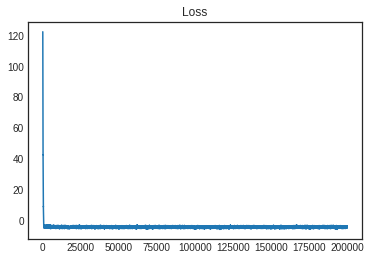

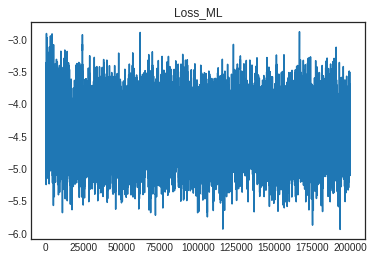

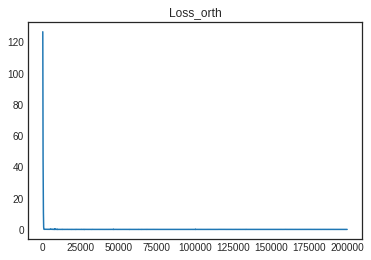

In [12]:
epochs = 200000
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_ML_hist)
plt.title("Loss_ML")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

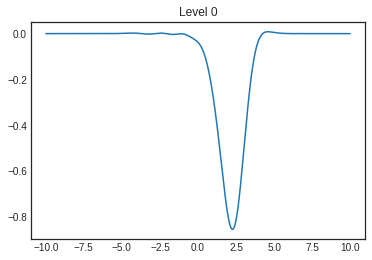

Square integrated over the region: 1.000000000000022


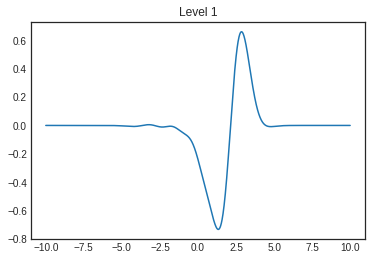

Square integrated over the region: 1.0000000000000218


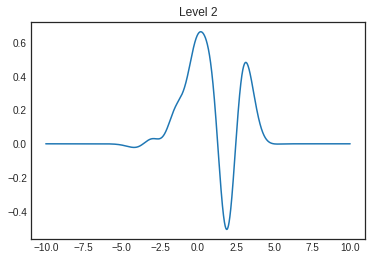

Square integrated over the region: 1.0000000000000213


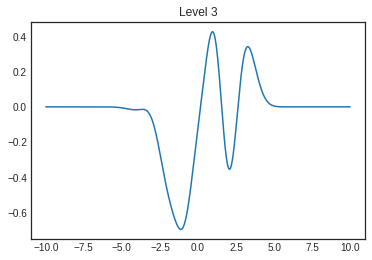

Square integrated over the region: 1.000000000000022


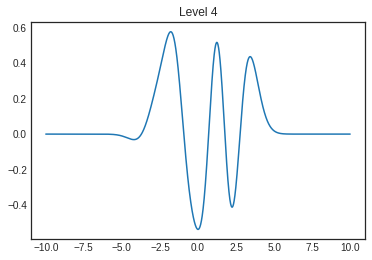

Square integrated over the region: 1.000000000000022


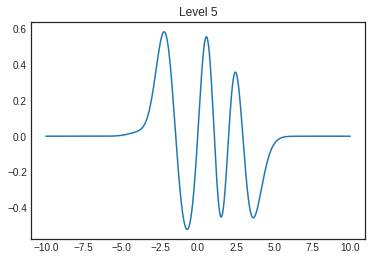

Square integrated over the region: 1.0000000000000222


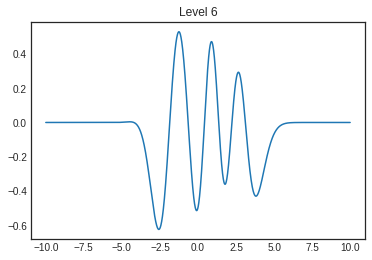

Square integrated over the region: 1.0000000000000222


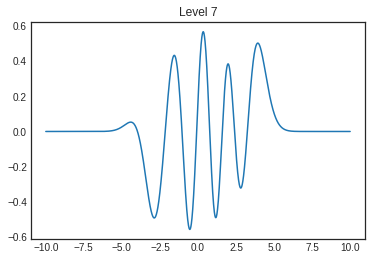

Square integrated over the region: 1.0000000000000224


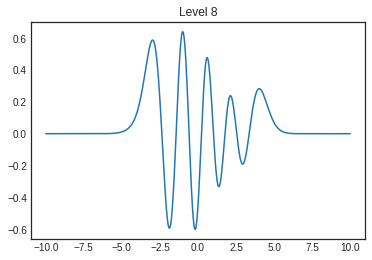

Square integrated over the region: 1.000000000000022


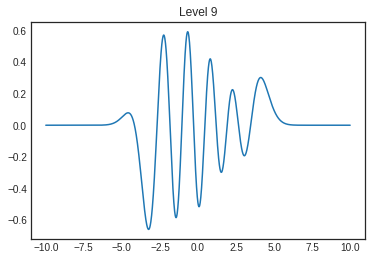

Square integrated over the region: 1.0000000000000222


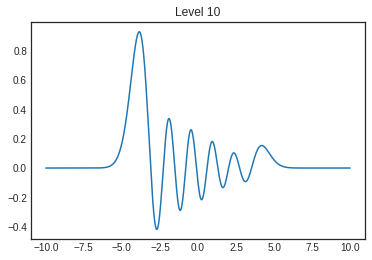

Square integrated over the region: 1.0000000000000233


In [13]:
x = np.arange(-10, 10 , 0.01)

Y = HM(n_Hm, x)

SUP = np.matmul(Y, var_HC_N)

for i in range(n_EL+1):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

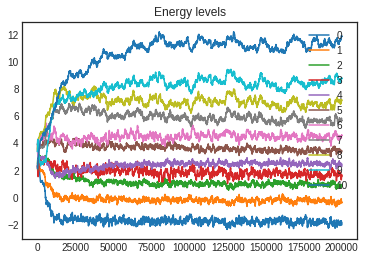

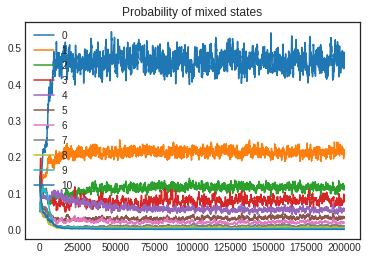

In [14]:
for i in range(n_EL+1):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [15]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-0.922383   -0.19468027  0.39259051  0.76323275  1.13212976  1.68230655
  2.29123962  2.82935516  3.59382452  4.39324974  5.94148555]
Probabilities: 
[0.45055448 0.21762563 0.12096551 0.08350139 0.05774093 0.03330773
 0.0181171  0.01057762 0.00492474 0.0022141  0.00047077]


In [16]:
print(np.matmul(var_HC_N.T, var_HC_N))

[[ 1.00000000e+00  4.03232417e-03  2.71017981e-03  2.39080555e-03
   4.94669270e-04  1.76766886e-03  1.59254215e-03 -1.37609123e-03
  -4.86181696e-04 -5.64911440e-04 -2.84209946e-04]
 [ 4.03232417e-03  1.00000000e+00 -5.83244429e-05  3.07645263e-03
   8.64578180e-04  1.90580363e-03  1.69517724e-03  5.96309649e-04
   4.29252677e-05 -3.19755896e-04 -3.19958391e-04]
 [ 2.71017981e-03 -5.83244429e-05  1.00000000e+00 -3.17153218e-04
   2.58136783e-03  1.48531415e-03  2.73253013e-03 -1.44071813e-03
   1.87561836e-04  4.07013080e-04  1.20496499e-03]
 [ 2.39080555e-03  3.07645263e-03 -3.17153218e-04  1.00000000e+00
  -2.56374077e-03 -7.73379874e-03  2.10033369e-03 -3.93247069e-03
  -1.74211220e-03  3.19998587e-04  2.99482858e-04]
 [ 4.94669270e-04  8.64578180e-04  2.58136783e-03 -2.56374077e-03
   1.00000000e+00 -7.97270744e-04 -4.01010308e-03 -3.41053991e-03
  -2.53877101e-03 -8.76262631e-04 -7.22176645e-04]
 [ 1.76766886e-03  1.90580363e-03  1.48531415e-03 -7.73379874e-03
  -7.97270744e-04  